In [12]:
from support_functions import log_progress, clean_drugbank, query_chembl
import pandas as pd
import numpy as np
import itertools
from cmapPy.pandasGEXpress import parse
import requests
from scipy.stats import kendalltau
import pickle
import os
import glob
import humanize
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)

In [13]:
# Visualization Parameters
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

___
# Exploratory analysis of LINCS gene expression data

Data downloaded from:
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE92742

LINCS data User Guide: 
https://docs.google.com/document/d/1q2gciWRhVCAAnlvF2iRLuJ7whrGP6QjpsCMq1yWz7dU/

Here we'll just take an initial, exploratory look at the gene expression data from the drug treatment and gene knockdown experiments in the LINCS library. 

___
## How BIG is this data, exactly?

In [27]:
# protein-protein interactions
string_db_size = (os.path.getsize('data/9606.protein.actions.v10.5.txt') +
                  os.path.getsize('data/9606.protein.aliases.v10.5.txt') +
                  os.path.getsize('data/9606.protein.links.v10.5.txt'))

# drug interactions
drugbank_db_size = os.path.getsize('data/full_drugbank_database.xml')

# LINCS metadata
metadata_size = 0
for f in glob.glob('data/*LINCS*.txt'):
    metadata_size += os.path.getsize(f)
    
# LICNS gene expression signatures
ge_data_size = (os.path.getsize('data/GSE70138_Broad_LINCS_Level5_COMPZ_n118050x12328_2017-03-06.gctx') +
                os.path.getsize('data/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx'))

# Consensus signatures
consensus_file = '/Users/Nico/Desktop/NFkB_Project/correlation_data_analysis/consensi-pert_id.tsv'
consensus_sig_size = os.path.getsize(consensus_file)

print('Amount of raw data used in this analysis:\n')
print('Protein-protein interaction:\t\t', humanize.naturalsize(string_db_size))
print('Drug interaction:\t\t\t', humanize.naturalsize(drugbank_db_size))
print('LINCS metadata:\t\t\t\t', humanize.naturalsize(metadata_size))
print('LINCS gene expression signatures:\t', humanize.naturalsize(ge_data_size))
print('Consensus expression signatures:\t', humanize.naturalsize(consensus_sig_size))

Amount of raw data used in this analysis:

Protein-protein interaction:		 970.3 MB
Drug interaction:			 701.0 MB
LINCS metadata:				 389.7 MB
LINCS gene expression signatures:	 29.2 GB
Consensus expression signatures:	 244.0 MB


___
## What does a gene expression signature look like?

Let's pull an example consensus signature and see what it looks like. We'll start with the signature of an ABL1 knockdown:

In [28]:
consensi_df = pd.DataFrame.from_csv(consensus_file, sep='\t', header=0).T

In [67]:
ABL1_knockdown_sig = consensi_df['TRCN0000001500']
ABL1_expression_modulation = pd.Series(ABL1_knockdown_sig['25'])

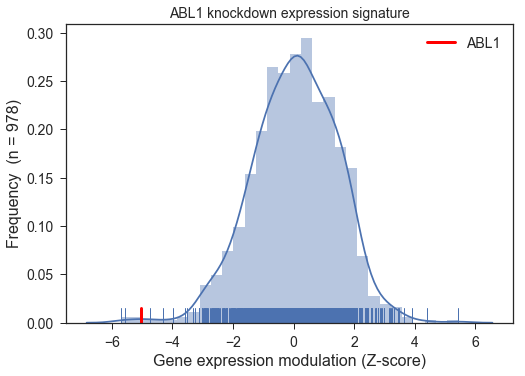

In [70]:
sns.distplot(ABL1_knockdown_sig, rug=True)
sns.rugplot(ABL1_expression_modulation, color='red', label='ABL1', linewidth=3)
plt.xlabel('Gene expression modulation (Z-score)')
plt.ylabel('Frequency  (n = 978)')
plt.title('ABL1 knockdown expression signature')
plt.legend()
plt.show()

The above plot shows the distribution of Z-scores of the 978 landmark genes whose expression was measured in the ABL1 knockdown experiment. Some genes are up-regulated and some genes are down-regulated, and the mean of the distribution is around 0. As we expect, the expression level of ABL1 is severely decreased when the gene is silenced. This is what 'knockdown' means.

___
## Are drug treatment signatures similar to gene knockdown signatures?

In [77]:
mebendazole_treatment_sig = consensi_df['BRD-K77987382']
bortezomib_treatment_sig = consensi_df['BRD-K88510285']
PSMA1_knockdown_sig = consensi_df['TRCN0000003870']

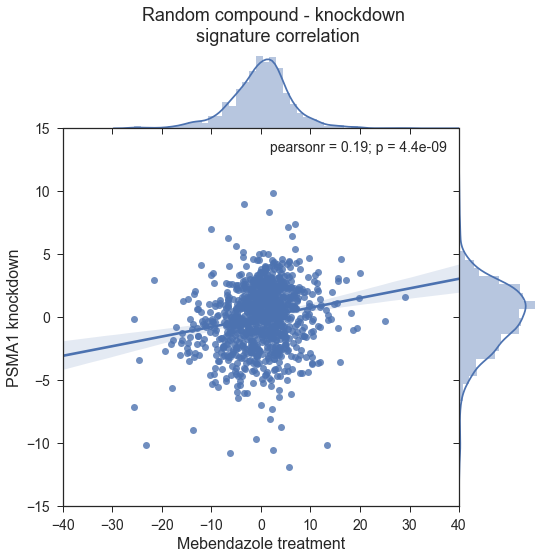

In [120]:
g1 = sns.jointplot(x=mebendazole_treatment_sig, y=PSMA1_knockdown_sig, 
                    kind="reg", size=8, space=0, xlim=(-40,40), ylim=(-15,15)
                  ).set_axis_labels("Mebendazole treatment", "PSMA1 knockdown")
plt.subplots_adjust(top=0.9)
g1.fig.suptitle('Random compound - knockdown \n signature correlation')
plt.show()

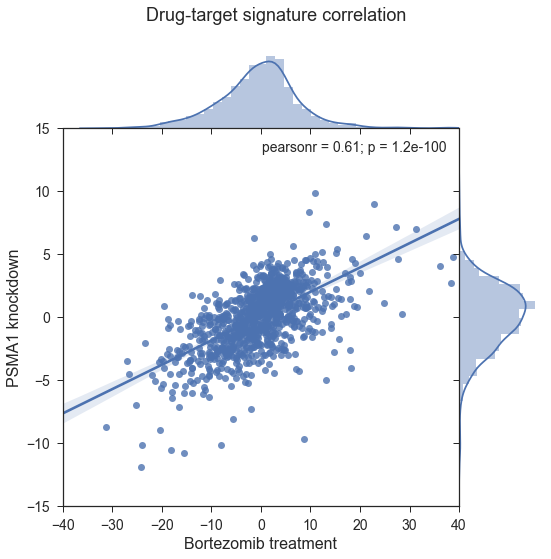

In [117]:
g2 = sns.jointplot(x=bortezomib_treatment_sig, y=PSMA1_knockdown_sig, 
                   kind="reg", size=8, space=0, xlim=(-40,40), ylim=(-15,15)
                  ).set_axis_labels("Bortezomib treatment", "PSMA1 knockdown")
plt.subplots_adjust(top=0.9)
g2.fig.suptitle('Drug-target signature correlation')
plt.show()

___
## Import LINCS metadata

In [6]:
# Phase 1 metadata:
# cell line information
cell_info_1 = pd.read_csv('data/GSE92742_Broad_LINCS_cell_info.txt', sep='\t', header=0)
# primary gene symbols and IDs
gene_info_1 = pd.read_csv('data/GSE92742_Broad_LINCS_gene_info.txt', sep='\t', header=0)
# Metadata describing each perturbagen used in experiments (pert_id)
pert_info_1 = pd.read_csv('data/GSE92742_Broad_LINCS_pert_info.txt', sep='\t', header=0)
# Metadata for signatures of aggregated replicates (level 5 data)
sig_info_1 = pd.read_csv('data/GSE92742_Broad_LINCS_sig_info.txt', sep='\t', header=0, dtype={'pert_dose': float})
# Calculated / derived / inferred metrics and annotations associated with each signature in the Level 5 matrix
sig_metrics_1 = pd.read_csv('data/GSE92742_Broad_LINCS_sig_metrics.txt', sep='\t', header=0)

# Phase 2 metadata:
pert_info_2 = pd.read_csv('data/GSE70138_Broad_LINCS_pert_info.txt', sep='\t', header=0)
sig_info_2 = pd.read_csv('data/GSE70138_Broad_LINCS_sig_info_2017-03-06.txt', sep='\t', header=0, dtype={'pert_dose': float})
sig_metrics_2 = pd.read_csv('data/GSE70138_Broad_LINCS_sig_metrics_2017-03-06.txt', sep='\t', header=0)

# Combine Phase 1 & 2 data:
pert_info = pd.concat([pert_info_1, pert_info_2], ignore_index=True)
sig_info = pd.concat([sig_info_1, sig_info_2], ignore_index=True)
sig_metrics = pd.concat([sig_metrics_1, sig_metrics_2], ignore_index=True)

In [16]:
sig_info.sample(5)

,cell_id,distil_id,pert_dose,pert_dose_unit,pert_id,pert_idose,pert_iname,pert_itime,pert_time,pert_time_unit,pert_type,sig_id
129087,A549,CPC016_A549_24H_X1_F1B6_DUO52HI53LO:L03|CPC016...,10.0,µM,BRD-K78844995,10 µM,BRD-K78844995,24 h,24.0,h,trt_cp,CPC016_A549_24H:BRD-K78844995-001-01-8:10
453222,A375,OEB006_A375_96H_X2_B3_DUO52HI53LO:I24|OEB006_A...,2.0,µL,ccsbBroad304_06058,2 µL,CSNK2B,96 h,96.0,h,trt_oe,OEB006_A375_96H:BRDN0000460569:-666
257666,VCAP,ERGK011_VCAP_120H_X1_B2_DUO52HI53LO:D15|ERGK01...,5.0,µL,TRCN0000003102,5 µL,JAK1,120 h,120.0,h,trt_sh,ERGK011_VCAP_120H:TRCN0000003102:-666
42231,HA1E,CPC002_HA1E_24H_X1_B3_DUO52HI53LO:B03|CPC002_H...,10.0,µM,BRD-A19037878,10 µM,trichostatin-a,24 h,24.0,h,trt_cp,CPC002_HA1E_24H:BRD-A19037878:10
388150,HCC515,KDD002_HCC515_96H_X1_B5_DUO52HI53LO:A08|KDD002...,3.0,µL,TRCN0000060430,3 µL,UIMC1,96 h,96.0,h,trt_sh,KDD002_HCC515_96H:TRCN0000060430:-666


In [17]:
sig_metrics.sample(5)

,Unnamed: 0,distil_cc_q75,distil_nsample,distil_ss,is_exemplar,ngenes_modulated_dn_lm,ngenes_modulated_up_lm,pct_self_rank_q25,pert_id,pert_iname,pert_type,sig_id,tas
31493,NaN,0.090836,2,3.70234,1.0,11,9,-666.0000,CGS001-29760,BLNK,trt_sh.cgs,CGS001_PC3_96H:BLNK:2,0.341011
2449,NaN,0.246116,3,3.30516,1.0,7,4,-666.0000,CGS001-10109,ARPC2,trt_sh.cgs,CGS001_A375_96H:ARPC2:1,0.330721
290558,NaN,0.410000,3,3.26341,1.0,19,12,0.0000,TRCN0000262167,FURIN,trt_sh,KDA006_PC3_96H:TRCN0000262167:-666,0.250766
213455,NaN,0.080000,3,3.72797,1.0,21,18,24.3408,BRD-K83448671,BRD-K83448671,trt_cp,DOS033_PC3_24H:BRD-K83448671-001-01-2:5.08,0.127265
290120,NaN,0.410000,3,2.76539,0.0,13,8,0.0000,TRCN0000055994,CLTB,trt_sh,KDA006_PC3_144H:TRCN0000055994:-666,0.212782


## LINCS perturbation types

What types of gene expression perturbation experiments are most common in the LINCS libray? From the plot below we see that the most common perturbations by far are small molecule compounds (trt_cp) and gene knockdowns (trt_sh). That's good for us, since these are the gene expression profiles we'll be using to predict drug-target interactions.

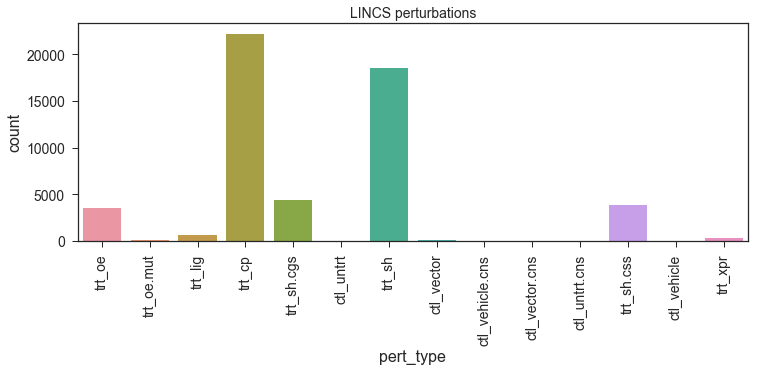

In [66]:
plt.figure(figsize=(12, 4))
sns.countplot(x="pert_type", data=pert_info)
plt.title("LINCS perturbations")
plt.xticks(rotation="vertical")
plt.show()

___
## Redundancy and data quality

We can see from the plots below that many compound and knockdown experiments have been performed multiple times. This is partially due to them being performed in different cell lines, but there is also redundancy within individual cell lines. To construct our gene expression correlation features, we will need to select one **representative** gene expression signature for each compound / knockdown in each cell line.

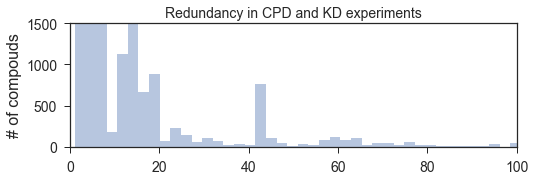

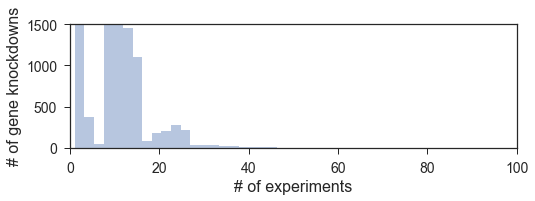

In [166]:
plt.figure(figsize=(8,5))
plt.subplot(211)
sns.distplot(sig_info[sig_info.pert_type == 'trt_cp'].pert_id.value_counts(), kde=False, bins=1000)
plt.xlim(0,100)
plt.ylim(0,1500)
plt.xlabel('')
plt.title('Redundancy in CPD and KD experiments')
plt.ylabel('# of compouds')
plt.show()

plt.figure(figsize=(8,5))
plt.subplot(212)
sns.distplot(sig_info[sig_info.pert_type == 'trt_sh'].pert_id.value_counts(), kde=False, bins=100)
plt.xlim(0,100)
plt.ylim(0,1500)
plt.xlabel('# of experiments')
plt.ylabel('# of gene knockdowns')
plt.show()

The plot below shows that most experiments are performed in only a subset of the posible cell lines in LINCS. Many cell lines have very little data.

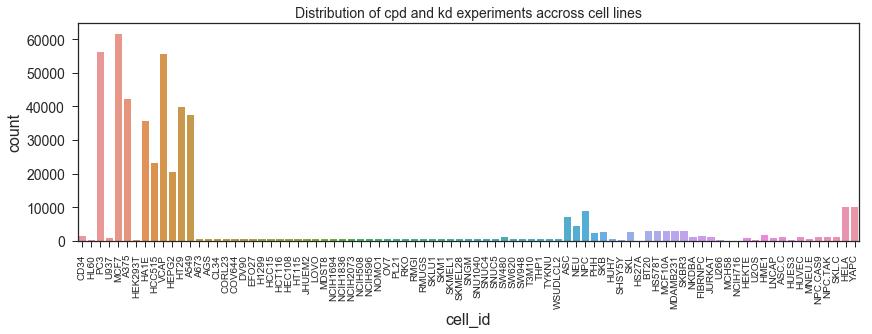

In [175]:
plt.figure(figsize=(14, 4))
sns.countplot(x="cell_id", 
              data=sig_info[(sig_info.pert_type == 'trt_sh') | 
                            (sig_info.pert_type == 'trt_cp')])
plt.title("Distribution of cpd and kd experiments accross cell lines")
plt.xticks(rotation="vertical", fontsize=10)
plt.show()

Data quality is not consistent accross repeat experiments of the same compound / knockdown in the same cell line. There are several measures of data quality that we are interested in, and which we can use to select **representative** signatures. Some of these are listed below and descibed in further detail in the LINCS data User Guide linked above.

- **pct_self_rank_q25**:  Self connectivity of replicates expressed as a percentage of total instances in a replicate set.
- **distil_cc_q75**:  75th quantile of pairwise spearman correlations in landmark space of replicate level 4 profiles.
- **tas**: Transcriptional activity score, a measure of the L1000 transcriptional response elicited by a perturbagen. TAS is computed as the geometric mean of the signature strength and the 75th quantile of pairwise replicate correlations for a given signature

The plots below show the joint and marginal distributions of these metrics for LINCS drug treatment and gene knockdown experiments

In [ ]:
# get all relevant signature quality info into one dataframe
all_sig_info = pd.concat([sig_info.pert_type, sig_metrics[['distil_cc_q75', 'pct_self_rank_q25', 'tas']]], axis=1)

# remove samples with missing or spurious data
sig_quality_info = all_sig_info[(all_sig_info.distil_cc_q75 > -1)
                                & (all_sig_info.pct_self_rank_q25 > -1)]

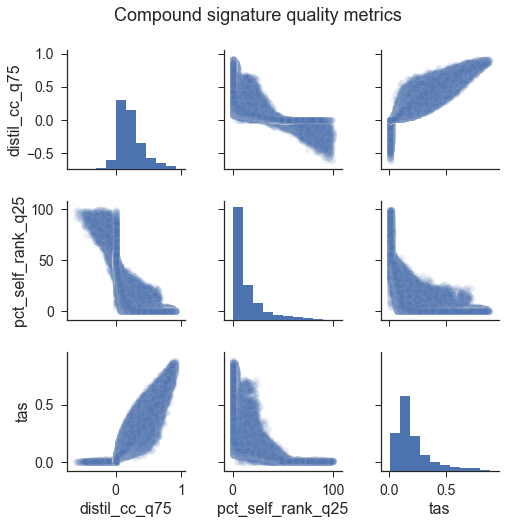

In [145]:
# compound treatment experiments
cpd_sig_quality_info = sig_quality_info[sig_quality_info.pert_type == 'trt_cp']
g = sns.pairplot(cpd_sig_quality_info,  plot_kws={'alpha': 0.1})
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Compound signature quality metrics')
plt.show()

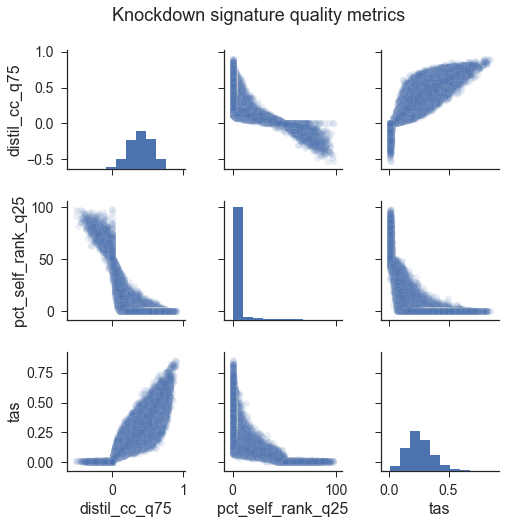

In [158]:
# knockdown treatment experiments
kd_sig_quality_info = sig_quality_info[sig_quality_info.pert_type == 'trt_sh']
g = sns.pairplot(kd_sig_quality_info,  plot_kws={'alpha': 0.1})
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Knockdown signature quality metrics')
plt.show()

___

We can use the above data quality measures to select representative signatures when multiple are available for a given perturbagen in a given cell line. We follow the selction criteria outlined in the user guide, which defines **gold** signatures as follows:

*A heuristic for assessing whether a signature is reproducible and distinct. Requirements include: distil_cc_q75 >= 0.2 and pct_self_rank_q25 <= 0.05.*

The plot below shows the breakdown of gold LINCS signatures by perturbation type. We see that there are nearly 100k gold knockdown signatures, and over 20k gold compound signatures.

In [159]:
gold_sigs = all_sig_info[(all_sig_info['distil_cc_q75'] >= 0.2) 
                         & (all_sig_info['pct_self_rank_q25'] <= 0.05)
                        ].reset_index(drop=True)
gold_sigs.to_csv('checkpoint_files/gold_sigs.csv')

In [1]:
plt.figure(figsize=(12, 4))
sns.countplot(x="pert_type", data=gold_sigs)
plt.title("High Quality Signatures")
plt.xticks(rotation="vertical")
plt.show()

NameError: name 'plt' is not defined

If multiple **gold** signatures are available for a compound or knockdown in a given cell line, we will follow CMAP guidelines and select as representative the gold signature with the highest **TAS**:

*Due to the redundancy of the CMap database, meaning that some perturbagens have many signatures even within the same cell line, it is convenient to identify a single ‘exemplar’ signature for each perturbagen in each cell line. These signatures are specifically designated for further analysis, such as ICC and aggregate TAS. Exemplar signatures were selected according to the following process. For each perturbagen in each cell line:
If possible, consider only signatures with between 2 and 6 replicates.
Within these signatures, select the one with highest transcriptional activity score (TAS). See tas for more details.
If there are no signatures that have between 2 and 6 replicates, simply select the one with highest TAS.*

___
# Compounds with known protein targets

We need known (True) drug-target interactions to train our classifier. How many LINCS compounds are drugs or chemical probes with known protein targets? To answer this question, we can use the DrugBank (https://www.drugbank.ca/) and ChEMBL (https://www.ebi.ac.uk/chembl/) databases. 

For clarity and organization, we deal with mining these databases in a separate notebook called: `known_target_mining.ipynb`. Here, we'll just briefly summarize the results:

In [180]:
# Load targets extracted from Drugbank and Chembl
LINCS_target_dict = pickle.load(open('checkpoint_files/LINCS_target_dict.sav', 'rb'))

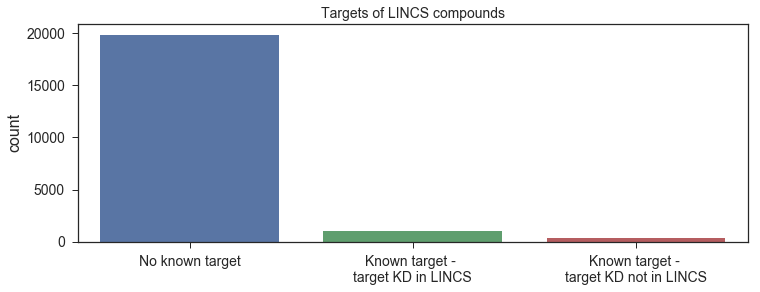

In [229]:
# Find drugs with known targets and which of those targets have been knocked down
all_LINCS_cpd_ids = pert_info[pert_info.pert_type == 'trt_cp'].pert_id.unique().astype(str)
all_LINCS_kd_genes = set(pert_info[pert_info.pert_type == 'trt_sh'].pert_iname.unique().astype(str))
all_targets = [ LINCS_target_dict[cpd] if cpd in LINCS_target_dict.keys() else set() for cpd in all_LINCS_cpd_ids ]
all_targets_bool = [ len(s) > 0 for s in all_targets ]
LINCS_targets = [ s.intersection(all_LINCS_kd_genes) for s in all_targets ]
LINCS_targets_bool = [ len(s) > 0 for s in LINCS_targets ]
target_class = []
for i, label in enumerate(LINCS_targets_bool):
    if label: target_class.append('Known target - \ntarget KD in LINCS')
    elif all_targets_bool[i]: target_class.append('Known target - \ntarget KD not in LINCS')
    else: target_class.append('No known target')
target_df = pd.DataFrame({'pert_id':all_LINCS_cpd_ids, 'target':target_class})

# plot results
plt.figure(figsize=(12,4))
sns.countplot(x="target", data=target_df)
plt.title('Targets of LINCS compounds')
plt.xticks(fontsize=14)
plt.xlabel('')
plt.show()

As we can see in the plot above, most compounds tested in LINCS have no known targets. Of the compounds with known targets, the majority have targets that have been knocked down in LINCS experiments. This is good because we need both the compound signature and the target knockdown signature in order to predict whether an interaction is taking place.